In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [6]:
import tensorflow.keras as layers

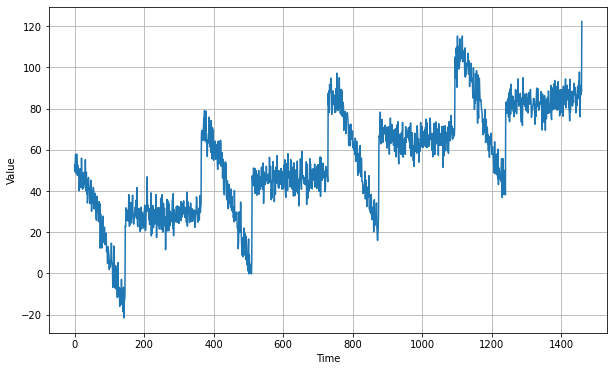

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    # Just an arbitrary pattern, you can change it if you wish
    return np.where(season_time<0.4,
                   np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    # repeat the same pattern at each period
    season_time=((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

def white_noise(time,noise_level,seed=None):
    rnd=np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

amplitude=40
series=seasonality(time,period=365,amplitude=amplitude)

slope=0.05
series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)

noise_level=5
noise=white_noise(time,noise_level,seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series);

In [9]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset=dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset=dataset.shuffle(shuffle_buffer)
    dataset=dataset.map(lambda window: (window[:-1],window[-1:]))
    dataset=dataset.batch(batch_size).prefetch(1)
    return dataset

In [10]:
split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set=window_dataset(x_train,window_size)
valid_set=window_dataset(x_valid,window_size)

model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(1,input_shape=[window_size])
])

optimizers=tf.keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizers,
              metrics=['mae'])

model.fit(train_set,epochs=100,validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 42ms/step - loss: 46.5854 - mae: 47.9542 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 11.8285 - mae: 11.9459 - val_loss: 9.2357 - val_mae: 9.6871
Epoch 3/100
31/31 [==============================] - 1s 27ms/step - loss: 10.1682 - mae: 10.3805 - val_loss: 9.1530 - val_mae: 9.6008
Epoch 4/100
31/31 [==============================] - 1s 26ms/step - loss: 9.8548 - mae: 10.2880 - val_loss: 9.2402 - val_mae: 9.5627
Epoch 5/100
31/31 [==============================] - 1s 24ms/step - loss: 9.3782 - mae: 10.1772 - val_loss: 8.8791 - val_mae: 9.4029
Epoch 6/100
31/31 [==============================] - 1s 25ms/step - loss: 9.5393 - mae: 10.0866 - val_loss: 8.9816 - val_mae: 9.3764
Epoch 7/100
31/31 [==============================] - 1s 24ms/step - loss: 9.4518 - mae: 9.9598 - val_loss: 9.1477 - val_mae: 9.6448
Epoch 8/100
31/31 [==============================] - 1s 25m

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set=window_dataset(x_train,window_size)
valid_set=window_dataset(x_valid,window_size)

model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(1,input_shape=[window_size])
])

LR_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-6*pow(10,(epoch/30)))

optimizers=tf.keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizers,
              metrics=['mae'])

history=model.fit(train_set,epochs=100,callbacks=[LR_schedule])

Epoch 1/100
31/31 [==============================] - 1s 33ms/step - loss: 82.9574 - mae: 83.6628
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 67.4675 - mae: 68.1054
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 49.7027 - mae: 50.2020
Epoch 4/100
31/31 [==============================] - 0s 16ms/step - loss: 30.6385 - mae: 31.0492
Epoch 5/100
31/31 [==============================] - ETA: 0s - loss: 14.7969 - mae: 15.290 - 0s 15ms/step - loss: 14.3104 - mae: 14.7116
Epoch 6/100
31/31 [==============================] - 0s 16ms/step - loss: 10.0925 - mae: 10.5442
Epoch 7/100
31/31 [==============================] - 1s 17ms/step - loss: 9.9847 - mae: 10.5033
Epoch 8/100
31/31 [==============================] - 1s 16ms/step - loss: 10.0107 - mae: 10.5074
Epoch 9/100
31/31 [==============================] - 1s 16ms/step - loss: 10.0127 - mae: 10.4724
Epoch 10/100
31/31 [==============================] - 1s 16ms/step - loss: 9.9902 - mae:

(1e-06, 0.001, 0.0, 20.0)

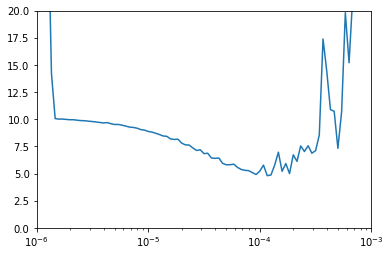

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set=window_dataset(x_train,window_size)
valid_set=window_dataset(x_valid,window_size)

model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(1,input_shape=[window_size])
])

optimizers=tf.keras.optimizers.SGD(learning_rate=1e-4,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizers,
              metrics=['mae'])

model.fit(train_set,epochs=100,validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 43ms/step - loss: 30.2880 - mae: 31.1798 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 1s 26ms/step - loss: 10.0185 - mae: 10.3285 - val_loss: 8.1600 - val_mae: 8.6094
Epoch 3/100
31/31 [==============================] - 1s 26ms/step - loss: 8.6760 - mae: 8.9101 - val_loss: 12.8805 - val_mae: 13.4546
Epoch 4/100
31/31 [==============================] - 1s 26ms/step - loss: 8.4433 - mae: 8.8047 - val_loss: 8.4305 - val_mae: 8.7785
Epoch 5/100
31/31 [==============================] - 1s 27ms/step - loss: 7.2541 - mae: 7.7420 - val_loss: 6.9142 - val_mae: 7.4354
Epoch 6/100
31/31 [==============================] - 1s 26ms/step - loss: 7.3628 - mae: 8.2187 - val_loss: 7.0730 - val_mae: 7.4759
Epoch 7/100
31/31 [==============================] - 1s 23ms/step - loss: 6.2350 - mae: 6.7021 - val_loss: 7.2197 - val_mae: 7.7033
Epoch 8/100
31/31 [==============================] - 1s 24ms/s

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set=window_dataset(x_train,window_size)
valid_set=window_dataset(x_valid,window_size)

model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,activation="relu",input_shape=[window_size])
])

optimizers=tf.keras.optimizers.SGD(learning_rate=1e-4,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizers,
              metrics=['mae'])

early_stopping=tf.keras.callbacks.EarlyStopping(patience=10)

history=model.fit(train_set,epochs=500,validation_data=valid_set,callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 48ms/step - loss: 25.4255 - mae: 26.0714 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
31/31 [==============================] - 1s 28ms/step - loss: 23.0280 - mae: 23.6326 - val_loss: 37.9075 - val_mae: 38.4370
Epoch 3/500
31/31 [==============================] - 1s 25ms/step - loss: 23.0409 - mae: 23.3513 - val_loss: 37.2625 - val_mae: 37.6402
Epoch 4/500
31/31 [==============================] - 1s 24ms/step - loss: 22.5878 - mae: 23.1454 - val_loss: 36.8951 - val_mae: 37.2413
Epoch 5/500
31/31 [==============================] - 1s 25ms/step - loss: 22.4546 - mae: 22.9715 - val_loss: 36.6195 - val_mae: 37.2182
Epoch 6/500
31/31 [==============================] - 1s 25ms/step - loss: 22.2293 - mae: 22.8042 - val_loss: 36.6923 - val_mae: 37.0165
Epoch 7/500
31/31 [==============================] - 1s 25ms/step - loss: 22.0051 - mae: 22.6505 - val_loss: 36.2521 - val_mae: 36.8640
Epoch 8/500
31/31 [=======================

Epoch 61/500
31/31 [==============================] - 1s 29ms/step - loss: 20.4231 - mae: 20.8108 - val_loss: 34.8165 - val_mae: 35.2564
Epoch 62/500
31/31 [==============================] - 1s 29ms/step - loss: 20.3683 - mae: 20.7791 - val_loss: 34.7431 - val_mae: 35.3177
Epoch 63/500
31/31 [==============================] - 1s 30ms/step - loss: 20.3729 - mae: 20.7757 - val_loss: 34.7587 - val_mae: 35.2532
Epoch 64/500
31/31 [==============================] - 1s 36ms/step - loss: 20.4706 - mae: 20.7437 - val_loss: 34.6787 - val_mae: 35.2888
Epoch 65/500
31/31 [==============================] - 1s 29ms/step - loss: 20.3955 - mae: 20.7495 - val_loss: 34.6798 - val_mae: 35.1847
Epoch 66/500
31/31 [==============================] - 1s 26ms/step - loss: 19.9981 - mae: 20.7305 - val_loss: 34.6595 - val_mae: 35.2012
Epoch 67/500
31/31 [==============================] - 1s 30ms/step - loss: 20.3269 - mae: 20.7283 - val_loss: 34.6907 - val_mae: 35.1898
Epoch 68/500
31/31 [=====================

In [21]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [24]:
lin_forecast=model_forecast(model,series[split_time-window_size:-1],window_size)[:,0]

In [25]:
lin_forecast.shape

(461,)

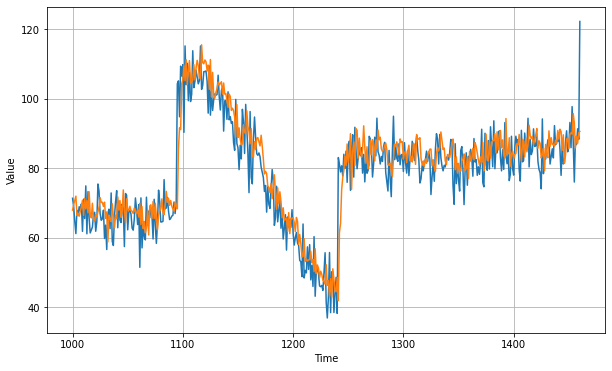

In [26]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid);
plot_series(time_valid, lin_forecast);

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.5486364

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set=window_dataset(x_train,window_size)
# valid_set=window_dataset(x_valid,window_size)

model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,activation="relu",input_shape=[window_size]),
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(1)
])

lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*pow(10,(epoch/20)))

optimizers=tf.keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizers,
              metrics=['mae'])

history=model.fit(train_set,epochs=100,callbacks=[lr_schedule]) #validation_data=valid_set

Epoch 1/100
31/31 [==============================] - 1s 35ms/step - loss: 43.7540 - mae: 44.3312
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 41.3574 - mae: 42.0073
Epoch 3/100
31/31 [==============================] - 1s 17ms/step - loss: 38.5907 - mae: 39.1402
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 35.2973 - mae: 35.8227
Epoch 5/100
31/31 [==============================] - 1s 17ms/step - loss: 31.6483 - mae: 32.0831
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 27.4519 - mae: 27.9021
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 22.8110 - mae: 23.2716
Epoch 8/100
31/31 [==============================] - 1s 17ms/step - loss: 17.8342 - mae: 18.2723
Epoch 9/100
31/31 [==============================] - 1s 17ms/step - loss: 12.6880 - mae: 13.1545
Epoch 10/100
31/31 [==============================] - 1s 16ms/step - loss: 8.5515 - mae: 9.0650
Epoch 11/100
31/31 [===========

(1e-07, 0.005, 0.0, 30.0)

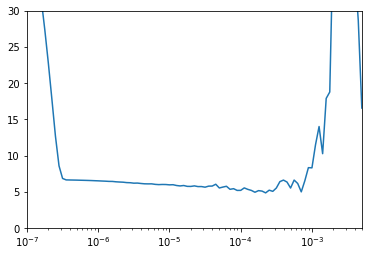

In [31]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set=window_dataset(x_train,window_size)
valid_set=window_dataset(x_valid,window_size)

model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,activation="relu",input_shape=[window_size]),
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(1)
])

# lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*pow(10,(epoch/20)))

optimizers=tf.keras.optimizers.SGD(learning_rate=0.000055,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizers,
              metrics=['mae'])

early_stopping=tf.keras.callbacks.EarlyStopping(patience=10)

history=model.fit(train_set,epochs=500,validation_data=valid_set,callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 2s 53ms/step - loss: 14.7829 - mae: 15.5073 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
31/31 [==============================] - 1s 30ms/step - loss: 8.0299 - mae: 8.4315 - val_loss: 7.3717 - val_mae: 7.7830
Epoch 3/500
31/31 [==============================] - 1s 29ms/step - loss: 7.3938 - mae: 7.6442 - val_loss: 6.3682 - val_mae: 6.7841
Epoch 4/500
31/31 [==============================] - 1s 26ms/step - loss: 6.7550 - mae: 7.1286 - val_loss: 6.1461 - val_mae: 6.5011
Epoch 5/500
31/31 [==============================] - 1s 28ms/step - loss: 6.2668 - mae: 6.7058 - val_loss: 6.7424 - val_mae: 7.3270
Epoch 6/500
31/31 [==============================] - 1s 26ms/step - loss: 5.9872 - mae: 6.5319 - val_loss: 6.9219 - val_mae: 7.2319
Epoch 7/500
31/31 [==============================] - 1s 27ms/step - loss: 5.7732 - mae: 6.2954 - val_loss: 5.9071 - val_mae: 6.4044
Epoch 8/500
31/31 [==============================] - 1s 27ms/step 

In [37]:
dense_forecast=model_forecast(model,series[split_time-window_size:-1],window_size)[:,0]

In [38]:
dense_forecast.shape

(461,)

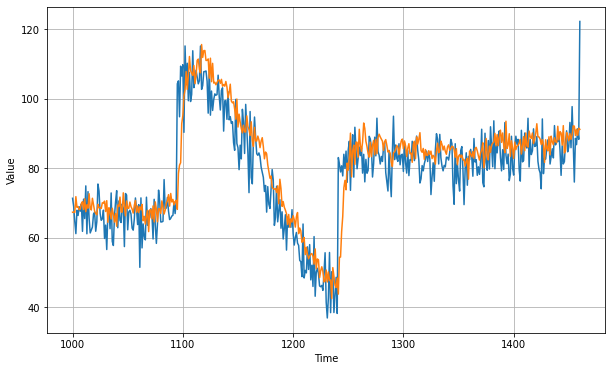

In [39]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid);
plot_series(time_valid, dense_forecast);

In [40]:
tf.keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.9539695